In [161]:
import statsmodels
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import os
import seaborn as sns

import sklearn
import torch
import torch.nn

from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler


DATA_DIR = './data/'

### Metrics functions

In [162]:
def mrse(actuals, preds):
    actuals = np.array(actuals)
    preds = np.array(preds)

    denom = np.sqrt(np.sum(np.square(actuals - np.mean(actuals))))
    num = np.sqrt(np.sum(np.square(actuals - preds)))

    return 1.0*num/denom

def re(actuals, preds):
    actuals = np.array(actuals)
    preds = np.array(preds)
    denom = np.sqrt(np.sum(np.square(actuals)))
    num = np.sqrt(np.sum(np.square(actuals - preds)))
    return 1.0*num/denom

## Reading Nino 3.4 data

In [163]:
filename = 'nino34_data.txt'

In [164]:
data = open(DATA_DIR + filename)
data_dict = {}

for line in data.readlines()[1:-3]:
    
    tokens = line.split(' ')
    values = []
    for token in tokens:
        if token == '':
            pass
        else:
            if '\n' in token:
                token = token[:-2]
            values.append(float(token))
    data_dict.update({values[0]:values[1:]})

In [165]:
for key,value in data_dict.items():
    print(key,value)
    assert len(value) == 12

1948.0 [-99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.9]
1949.0 [-99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.9]
1950.0 [24.55, 25.06, 25.87, 26.28, 26.18, 26.46, 26.29, 25.88, 25.74, 25.69, 25.47, 25.2]
1951.0 [25.24, 25.71, 26.9, 27.58, 27.92, 27.73, 27.6, 27.02, 27.23, 27.2, 27.25, 26.9]
1952.0 [26.67, 26.74, 27.17, 27.8, 27.79, 27.18, 26.53, 26.3, 26.36, 26.26, 25.92, 26.2]
1953.0 [26.74, 27.0, 27.57, 28.04, 28.28, 28.12, 27.43, 26.94, 27.01, 26.87, 26.88, 27.0]
1954.0 [26.98, 27.03, 26.9, 26.64, 27.12, 26.8, 26.11, 25.43, 25.12, 25.23, 25.57, 25.2]
1955.0 [25.61, 25.81, 26.22, 26.6, 26.66, 26.55, 26.15, 25.51, 25.28, 24.41, 24.25, 24.5]
1956.0 [25.34, 25.76, 26.46, 26.85, 27.13, 26.81, 26.23, 25.68, 25.73, 25.75, 25.56, 25.7]
1957.0 [26.04, 26.54, 27.46, 28.23, 28.55, 28.36, 28.17, 27.69, 27.44, 27.42, 27.62, 27.9]
1958.0 [28.33, 28.24, 28.27, 28.27, 28.31, 27.99, 27.32, 26.85, 26.4, 26.45

## Filtering data to have 1950 - 2008

In [166]:
filtered_data = {int(year): data_dict[year] for year in data_dict.keys() if year >= 1950 and year <=2008 }

In [167]:
for key,value in filtered_data.items():
    print(key,value)
    assert len(value) == 12

1950 [24.55, 25.06, 25.87, 26.28, 26.18, 26.46, 26.29, 25.88, 25.74, 25.69, 25.47, 25.2]
1951 [25.24, 25.71, 26.9, 27.58, 27.92, 27.73, 27.6, 27.02, 27.23, 27.2, 27.25, 26.9]
1952 [26.67, 26.74, 27.17, 27.8, 27.79, 27.18, 26.53, 26.3, 26.36, 26.26, 25.92, 26.2]
1953 [26.74, 27.0, 27.57, 28.04, 28.28, 28.12, 27.43, 26.94, 27.01, 26.87, 26.88, 27.0]
1954 [26.98, 27.03, 26.9, 26.64, 27.12, 26.8, 26.11, 25.43, 25.12, 25.23, 25.57, 25.2]
1955 [25.61, 25.81, 26.22, 26.6, 26.66, 26.55, 26.15, 25.51, 25.28, 24.41, 24.25, 24.5]
1956 [25.34, 25.76, 26.46, 26.85, 27.13, 26.81, 26.23, 25.68, 25.73, 25.75, 25.56, 25.7]
1957 [26.04, 26.54, 27.46, 28.23, 28.55, 28.36, 28.17, 27.69, 27.44, 27.42, 27.62, 27.9]
1958 [28.33, 28.24, 28.27, 28.27, 28.31, 27.99, 27.32, 26.85, 26.4, 26.45, 26.75, 26.6]
1959 [27.07, 27.18, 27.47, 27.88, 27.7, 27.37, 26.44, 26.09, 25.92, 26.24, 26.04, 26.1]
1960 [26.27, 26.29, 26.98, 27.49, 27.68, 27.24, 26.88, 26.7, 26.44, 26.22, 26.26, 26.2]
1961 [26.23, 26.56, 26.94, 27.36,

## Reading Nino 3.4 Anomaly data

In [168]:
filename = 'nino34_anomalies.txt'

In [169]:
anomaly_data = open(DATA_DIR + filename)
anomaly_data_dict = {}

for line in anomaly_data.readlines():  
    _,year,value = line.split(' ')
    value = float(value[:-2])
    year = int(float(year))
    if year in anomaly_data_dict:
        anomaly_data_dict[year]=anomaly_data_dict[year]+[value]
    else:
        anomaly_data_dict.update({year:[value]})

In [170]:
for key,value in anomaly_data_dict.items():
    print(key,value)
    assert len(value) == 12

1950 [-2.0023333333333, -1.6816666666666, -1.3646666666666, -1.4296666666666, -1.632, -1.13, -0.88866666666666, -0.954, -0.98733333333332, -0.983, -1.1576666666666, -1.27]
1951 [-1.3123333333333, -1.0316666666666, -0.33466666666666, -0.12966666666667, 0.10799999999999, 0.13899999999999, 0.42133333333333, 0.18, 0.50266666666667, 0.52699999999999, 0.62233333333333, 0.34]
1952 [0.11766666666667, -0.0016666666666722, -0.06466666666666, 0.090333333333322, -0.022000000000009, -0.411, -0.64866666666666, -0.53399999999999, -0.36733333333332, -0.41, -0.70766666666666, -0.35099999999999]
1953 [0.18766666666667, 0.25833333333332, 0.33533333333333, 0.33033333333332, 0.46799999999999, 0.52, 0.25133333333333, 0.106, 0.28266666666667, 0.19699999999999, 0.25233333333333, 0.43]
1954 [0.42766666666667, 0.2883333333333, -0.33466666666666, -1.0696666666666, -0.692, -0.79, -1.0686666666666, -1.4, -1.6073333333333, -1.44, -1.0576666666666, -1.3]
1955 [-0.94233333333332, -0.93166666666667, -1.0146666666666, 

## Flattening time series data

In [173]:
filtered_ts = np.array([])
filtered_ts = np.array([np.concatenate((filtered_ts,val)) for val in filtered_data.values()]).flatten()

In [174]:
assert len(filtered_ts) == (2008-1950+1)*12

In [175]:
filtered_anomalies = np.array([])
filtered_anomalies = np.array([np.concatenate((filtered_anomalies,val)) for val in anomaly_data_dict.values()]).flatten()

In [176]:
assert len(filtered_anomalies) == (2008-1950+1)*12

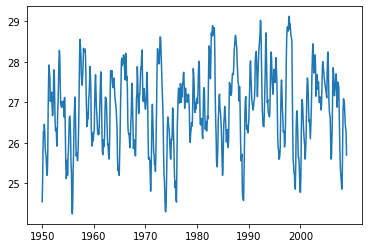

In [177]:
plt.plot(filtered_ts)
plt.xticks(range(0,708+1,12*10),labels=range(1950,2008+1,10))
plt.show()

In [178]:
def get_data(data,years,subtract_mean=False,means=None):
    if subtract_mean == True:
        assert means is not None
    filtered_data = {int(year): data[year] for year in data.keys() if year in years }
    filtered_ts = np.array([])
    if subtract_mean:
        filtered_ts = np.array([np.concatenate((filtered_ts,val-means)) for val in filtered_data.values()]).flatten()
    else:
        filtered_ts = np.array([np.concatenate((filtered_ts,val)) for val in filtered_data.values()]).flatten()
    return filtered_ts

### Train Test Split

In [179]:
train_test_ratio = 0.8
years = np.array(list(filtered_data.keys()))
print('Total years available')
print(years)
print(f'Train Test ratio: {train_test_ratio}')
training_years = years[:int(train_test_ratio*len(years))]
print(f'No of years in training: {len(training_years)}')
print(training_years)
testing_years = years[int(train_test_ratio*len(years)):]
print(f'No of years in testing: {len(testing_years)}')
print(testing_years)

Total years available
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008]
Train Test ratio: 0.8
No of years in training: 47
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996]
No of years in testing: 12
[1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008]


## Calculating monthly means across all training years

In [180]:
means = np.zeros(12)
for key,value in filtered_data.items():
    if int(key) in training_years:
        means += np.array(value)
means /= len(training_years)
print(means)

[26.43340426 26.63085106 27.10021277 27.51       27.61638298 27.42085106
 26.98765957 26.58851064 26.47744681 26.43723404 26.42957447 26.37021277]


In [181]:
for key,value in filtered_data.items():
    print(key,value-means)
    assert len(value) == 12

1950 [-1.88340426 -1.57085106 -1.23021277 -1.23       -1.43638298 -0.96085106
 -0.69765957 -0.70851064 -0.73744681 -0.74723404 -0.95957447 -1.17021277]
1951 [-1.19340426 -0.92085106 -0.20021277  0.07        0.30361702  0.30914894
  0.61234043  0.43148936  0.75255319  0.76276596  0.82042553  0.52978723]
1952 [ 0.23659574  0.10914894  0.06978723  0.29        0.17361702 -0.24085106
 -0.45765957 -0.28851064 -0.11744681 -0.17723404 -0.50957447 -0.17021277]
1953 [0.30659574 0.36914894 0.46978723 0.53       0.66361702 0.69914894
 0.44234043 0.35148936 0.53255319 0.43276596 0.45042553 0.62978723]
1954 [ 0.54659574  0.39914894 -0.20021277 -0.87       -0.49638298 -0.62085106
 -0.87765957 -1.15851064 -1.35744681 -1.20723404 -0.85957447 -1.17021277]
1955 [-0.82340426 -0.82085106 -0.88021277 -0.91       -0.95638298 -0.87085106
 -0.83765957 -1.07851064 -1.19744681 -2.02723404 -2.17957447 -1.87021277]
1956 [-1.09340426 -0.87085106 -0.64021277 -0.66       -0.48638298 -0.61085106
 -0.75765957 -0.908510

In [217]:
training_data = get_data(filtered_data,training_years,subtract_mean=True,means=means)
training_anomalies = get_data(anomaly_data_dict,training_years)

In [218]:
test_data = get_data(filtered_data,testing_years,subtract_mean=True,means=means)
test_anomalies = get_data(anomaly_data_dict,testing_years)

In [219]:
len(training_data),len(training_anomalies)

(564, 564)

In [220]:
assert len(training_years)*12 == len(training_data)
assert len(training_years)*12 == len(training_anomalies)

### Plotting training data, mean, acf and pacf

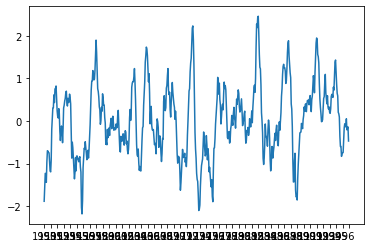

In [221]:
plt.plot(training_data)
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.show()

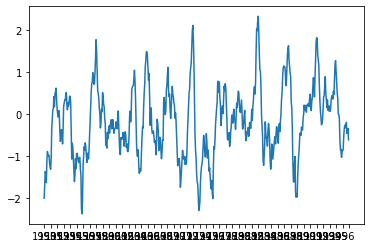

In [222]:
plt.plot(training_anomalies)
plt.xticks(range(0,len(training_anomalies)+1,12),labels=training_years)
plt.show()

### Plotting test data

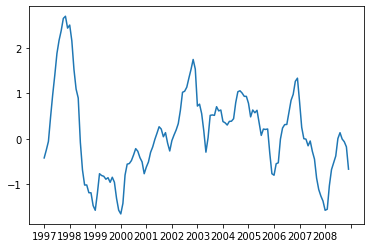

In [225]:
plt.plot(test_data)
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.show()

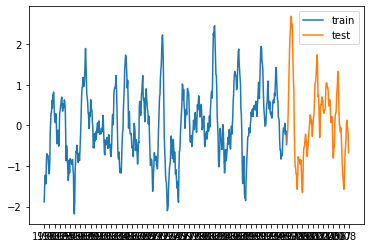

In [200]:
plt.plot(range(0,len(training_data)),training_data,label='train')
plt.plot(range(len(training_data),len(training_data)+len(test_data)),test_data,label='test')
plt.xticks(range(0,len(training_data)+len(test_data)+1,12),labels=list(training_years)+list(testing_years))
plt.legend()
plt.show()

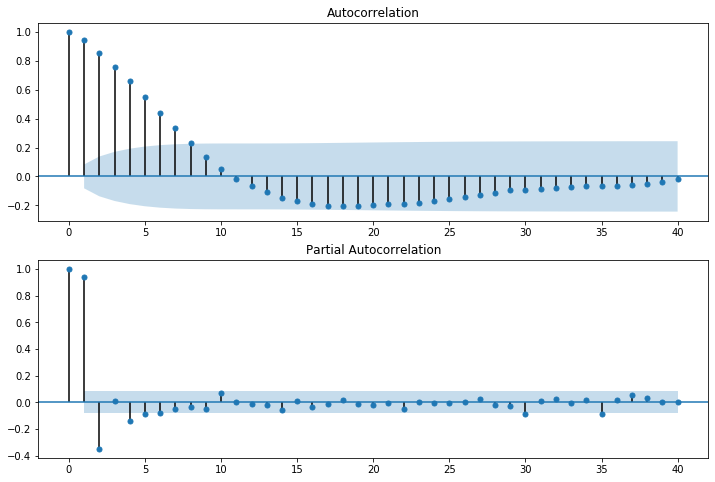

In [223]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(training_data, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(training_data, lags=40, ax=ax2)
plt.show()

## Generate Fake Non Linear data

In [28]:
year_begin=1950
year_end=1996
n_points = (year_end-year_begin+1)*12

In [29]:
p=2

init_val = [0,0]
theta = [0.6,0.3]
sigma = 0.1
assert len(theta) == p
assert len(init_val) == p

training_data = []
for i in range(n_points):
    w_i = np.random.normal(scale=sigma)
    if i==0:
        x_i = sum([np.power(init_val[k],2-k)*theta[k] for k in range(p)]) + w_i
    else:   
        x_i = sum([np.power(training_data[i-k-1],2-k)*theta[k] for k in range(p)]) + w_i
    training_data.append(x_i)

In [30]:
test_year_begin=1997
test_year_end=2008
n_test_points = (test_year_end-test_year_begin+1)*12
history = training_data.copy()
test_data = []
for i in range(n_points,n_points+n_test_points):
    w_i = np.random.normal(scale=sigma)
    x_i = sum([np.power(history[i-k-1],2-k)*theta[k] for k in range(p)]) + w_i
    history.append(x_i)
    test_data.append(x_i)

## Loading fake non linear data

In [215]:
p=2
LOAD_DATA = True
if LOAD_DATA:
    training_data = np.load('fake_nonlinear_training_data.npy')
    test_data = np.load('fake_nonlinear_test_data.npy')
else:
    np.save('fake_nonlinear_training_data.npy',training_data)
    np.save('fake_nonlinear_test_data.npy',test_data)

### Plotting training data, mean, acf and pacf

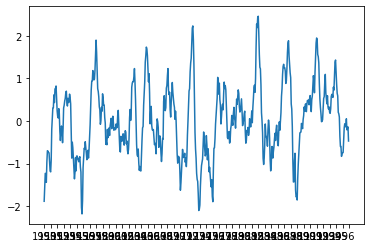

In [224]:
plt.plot(training_data)
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.show()

### Plotting test data

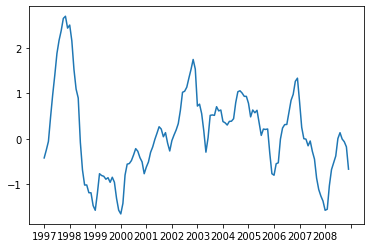

In [225]:
plt.plot(test_data)
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.show()

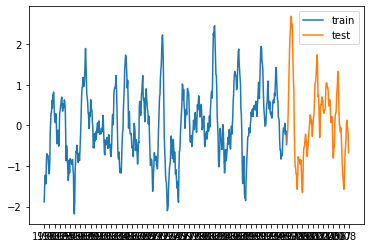

In [200]:
plt.plot(range(0,len(training_data)),training_data,label='train')
plt.plot(range(len(training_data),len(training_data)+len(test_data)),test_data,label='test')
plt.xticks(range(0,len(training_data)+len(test_data)+1,12),labels=list(training_years)+list(testing_years))
plt.legend()
plt.show()

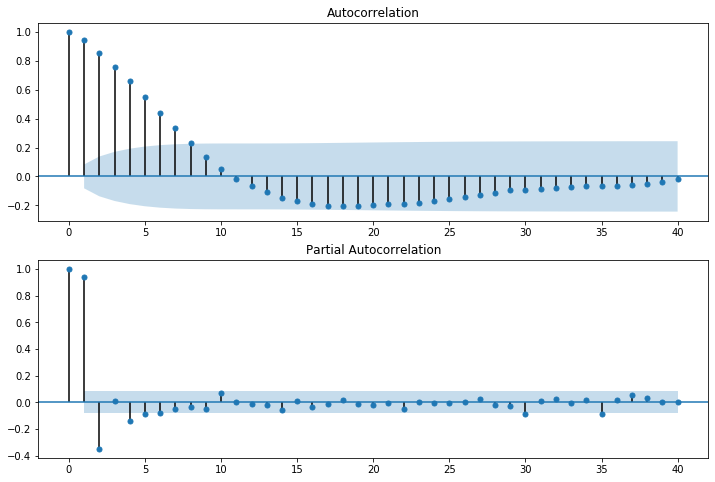

In [201]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(training_data, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(training_data, lags=40, ax=ax2)
plt.show()

### Fitting AR model

In [202]:
formatted_training_data = pd.Series(data=training_data,index=pd.Index(sm.tsa.datetools.dates_from_range(f'{training_years[0]}m1', length=len(training_data))))

In [203]:
arma_mod = sm.tsa.ARMA(formatted_training_data, (p,0)).fit(disp=False)
print(arma_mod.params)

const     -0.038012
ar.L1.y    1.326019
ar.L2.y   -0.394844
dtype: float64


/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

### Getting predictions for train set

In [204]:
training_predictions = arma_mod.predict(start=f'{training_years[0]}m1', end=f'{training_years[-1]}m12', dynamic=False)

/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


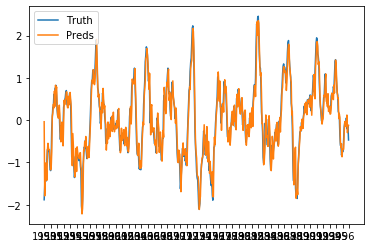

In [205]:
plt.plot(formatted_training_data.values,label='Truth')
plt.plot(training_predictions.values,label='Preds')
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.legend()
plt.show()

### Getting training residuals

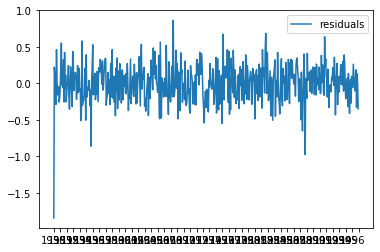

In [206]:
training_residuals = formatted_training_data.values-training_predictions.values
plt.plot(training_residuals,label='training_residuals')
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.legend()
plt.show()

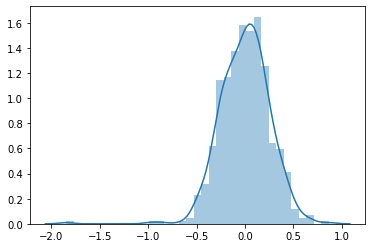

In [208]:
sns.distplot(training_residuals)

### Getting predictions for test set

In [209]:
history = list(formatted_training_data.values)
test_predictions = []
for t in range(len(test_data)):
    model = sm.tsa.ARMA(history, (p,0)).fit(disp=False)
    output = model.forecast()
    yhat = output[0][0]
    test_predictions.append(yhat)
    obs = test_data[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


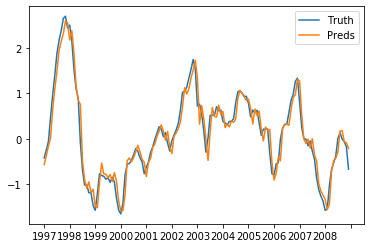

In [228]:
plt.plot(test_data,label='Truth')
plt.plot(test_predictions,label='Preds')
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.legend()
plt.show()

### Getting test residuals

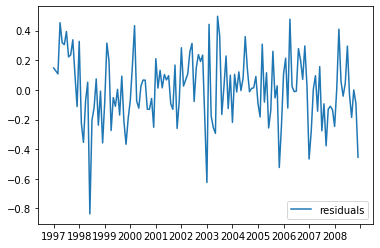

In [229]:
test_residuals = np.array(test_data)-np.array(test_predictions)
plt.plot(test_residuals,label='residuals')
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.legend()
plt.show()

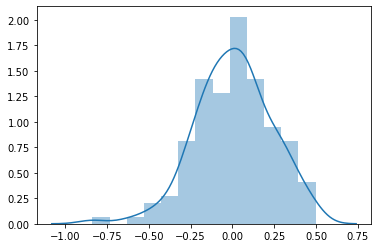

In [230]:
sns.distplot(test_residuals)

In [231]:
test_mrse = mrse(test_data,test_predictions)
test_re = re(test_data,test_predictions)
print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}')

Test MRSE: 0.24158928744102426
Test RE: 0.23997441270759517


In [232]:
training_data = training_residuals
test_data = test_residuals

### Scaling data

In [233]:
scaler = StandardScaler()
scaled_training_data = scaler.fit_transform(training_data.reshape(-1, 1))
scaled_test_data = scaler.transform(test_data.reshape(-1, 1))

In [234]:
# scaled_training_data = training_data - np.tile(means,int(len(training_data)/12))

# test_data = get_data(filtered_data,testing_years)
# test_anomalies = get_data(anomaly_data_dict,testing_years)
# scaled_test_data = test_data - np.tile(means,int(len(test_data)/12))

### Plotting scaled training data, acf and pacf

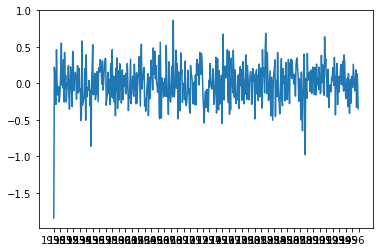

In [235]:
plt.plot(training_data)
#plt.plot(reqd_means)
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.show()

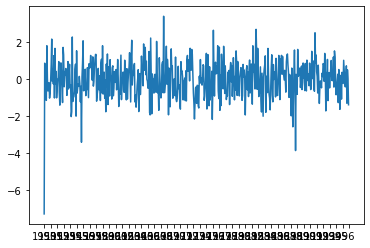

In [236]:
plt.plot(scaled_training_data)
#plt.plot(reqd_means)
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.show()

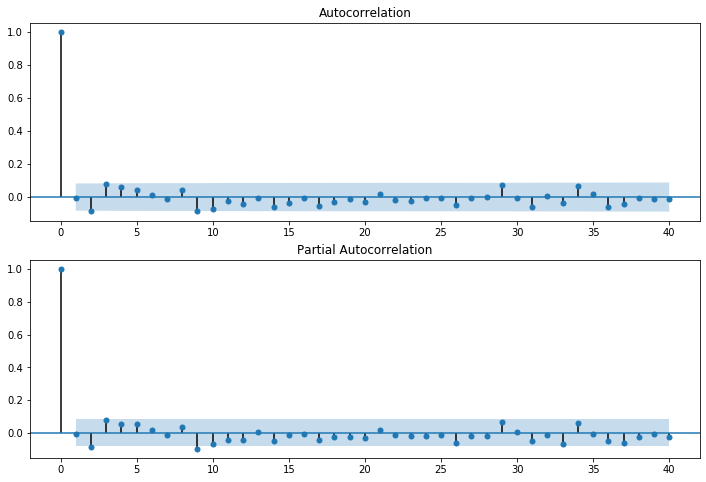

In [237]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(scaled_training_data, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(scaled_training_data, lags=40, ax=ax2)
plt.show()

In [238]:
train_data_normalized = torch.FloatTensor(scaled_training_data).view(-1)
train_window = 2

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

train_inout_seq[:5]

[(tensor([-7.2729,  0.8697]), tensor([0.4372])),
 (tensor([0.8697, 0.4372]), tensor([-0.8552])),
 (tensor([ 0.4372, -0.8552]), tensor([-1.1395])),
 (tensor([-0.8552, -1.1395]), tensor([1.8123])),
 (tensor([-1.1395,  1.8123]), tensor([0.0440]))]

In [239]:
test_data_normalized = torch.FloatTensor(scaled_test_data).view(-1)

test_inout_seq = create_inout_sequences(test_data_normalized, train_window)

test_inout_seq[:5]

[(tensor([0.5786, 0.4986]), tensor([0.4205])),
 (tensor([0.4986, 0.4205]), tensor([1.7809])),
 (tensor([0.4205, 1.7809]), tensor([1.2461])),
 (tensor([1.7809, 1.2461]), tensor([1.1987])),
 (tensor([1.2461, 1.1987]), tensor([1.5466]))]

In [240]:
print(f'scaled_training_data: {len(scaled_training_data)}\n\
scaled_test_data: {len(scaled_test_data)}\n\
training_data: {len(training_data)}\n\
test_data: {len(test_data)}\n\
train_inout_seq: {len(train_inout_seq)}\n\
test_inout_seq: {len(test_inout_seq)}\n\
')

scaled_training_data: 564
scaled_test_data: 144
training_data: 564
test_data: 144
train_inout_seq: 562
test_inout_seq: 142



In [241]:
import torch.nn as nn
import torch.optim as optim

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, num_hidden_layers=1, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_hidden_layers)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        #lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        lstm_out,_ = self.lstm(input_seq.view(len(input_seq) ,1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [242]:
input_size=1
num_hidden_layers=1
hidden_layer_size=10 
output_size=1

model = LSTM(input_size,hidden_layer_size,num_hidden_layers,output_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 10)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)


### Fitting LSTM model

In [243]:
def evaluate(rescale=True, display_plots=False):
    model.eval()
    scaled_predictions=[]
    scaled_actuals = []
    for i in range(len(test_inout_seq)):
        seq = torch.FloatTensor(test_inout_seq[i][0])
        scaled_actuals.append(test_inout_seq[i][1].item())
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            scaled_predictions.append(model(seq).item())
    if rescale:
        actuals = scaler.inverse_transform(np.array(scaled_actuals).reshape(-1, 1))
        predictions = scaler.inverse_transform(np.array(scaled_predictions).reshape(-1, 1))
    else:
        actuals=scaled_actuals
        predictions=scaled_predictions
    if display_plots:
        plt.plot(actuals,label='Truth')
        plt.plot(predictions,label='Preds')
        plt.xticks(range(0,len(scaled_test_data)+1,12),labels=testing_years)
        plt.legend()
        plt.show()
    test_mrse = mrse(actuals,predictions)
    test_re = re(actuals,predictions)
    return test_mrse,test_re
    #print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}')

In [244]:
PATH = 'best_r2n2_model.pth'

In [245]:
epochs = 40
best_test_metric = np.inf
best_model_params = model.state_dict()
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    test_mrse,test_re = evaluate()
    if i%5 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    test_metric = test_mrse 
    if(test_metric < best_test_metric):
        count = 0
        best_test_metric = test_metric
        torch.save({
            'state_dict': model.state_dict(),
            }, PATH)
        print(f"Best Model saved at epoch: {i} with metric: {best_test_metric}")
    else:
        count+=1
#     if(count >= 5):
#         print("Validation has not improved since 5 epochs. Early Stopping...")
#         break
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

Best Model saved at epoch: 0 with metric: 0.9959771410980398
epoch:   1 loss: 2.00393438
epoch:   6 loss: 1.93919885
epoch:  11 loss: 1.90527236
epoch:  16 loss: 1.88255274
epoch:  21 loss: 1.86754358
epoch:  26 loss: 1.85733306
epoch:  31 loss: 1.84993374
epoch:  36 loss: 1.84410262
epoch:  39 loss: 1.8411949873


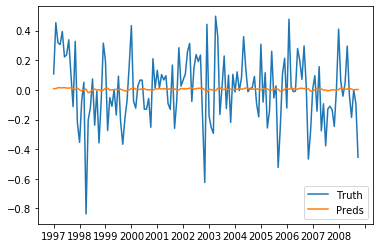

Test MRSE: 0.9959771410980398
Test RE: 0.9957845395189817


In [246]:
model_dict = torch.load(PATH)
model.load_state_dict(model_dict['state_dict'])
test_mrse,test_re = evaluate(rescale=True,display_plots=True)
print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}')

## Evaluate R2N2

In [247]:
def evaluate_r2n2(rescale=True, display_plots=False):
    model.eval()
    scaled_predictions=[]
    scaled_actuals = []
    for i in range(len(test_inout_seq)):
        seq = torch.FloatTensor(test_inout_seq[i][0])
        scaled_actuals.append(test_inout_seq[i][1].item())
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            scaled_predictions.append(model(seq).item())
    if rescale:
        actuals = scaler.inverse_transform(np.array(scaled_actuals).reshape(-1, 1))
        predictions = scaler.inverse_transform(np.array(scaled_predictions).reshape(-1, 1))
    else:
        actuals=scaled_actuals
        predictions=scaled_predictions
    actuals = actuals.reshape(-1)
    predictions = predictions.reshape(-1)
    a1 = actuals
    p1 = predictions
    actuals += test_data[:-train_window]
    predictions += test_predictions[:-train_window]
    if display_plots:
        plt.plot(actuals,label='Truth')
        plt.plot(predictions,label='Preds')
        plt.xticks(range(0,len(scaled_test_data)+1,12),labels=testing_years)
        plt.legend()
        plt.show()
    test_mrse = mrse(actuals,predictions)
    test_re = re(actuals,predictions)
    return test_mrse,test_re,a1,p1
    #print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}')

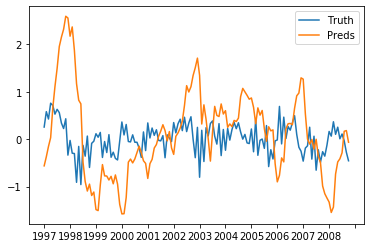

Test MRSE: 2.983433975381474
Test RE: 2.9803348598924746


In [248]:
test_mrse,test_re,a1,p1 = evaluate_r2n2(rescale=True,display_plots=True)
print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}')

In [249]:
a1

array([ 0.25509073,  0.5801082 ,  0.42452437,  0.757825  ,  0.71039113,
        0.52708768,  0.628989  ,  0.55954378,  0.33831051,  0.22457509,
        0.42969943, -0.33597416, -0.02690236, -0.29576528, -0.30256372,
       -0.90925508, -0.15302955, -0.95643128, -0.13049998, -0.35805926,
        0.06533316, -0.59618784, -0.08780404, -0.04284859,  0.11478017,
        0.04098963,  0.14179466, -0.38527788, -0.04925176, -0.28129565,
        0.09529398, -0.38122361, -0.2745596 , -0.40530182, -0.4378498 ,
       -0.02941525,  0.36200279,  0.08924633,  0.3094736 , -0.04953364,
       -0.05758633,  0.09137004, -0.06464559, -0.06554421, -0.18855546,
       -0.38324661,  0.15217082, -0.24054656,  0.34199151,  0.02509581,
        0.2347686 ,  0.08023072,  0.19831789, -0.02571432, -0.03601113,
        0.07441911, -0.39137813,  0.09086278,  0.02393288, -0.05068899,
        0.34981158,  0.13325641,  0.32348905,  0.42080167,  0.17957318,
        0.46182679,  0.15974592,  0.3399666 ,  0.47229139, -0.00

In [250]:
p1

array([-5.62415142e-01, -3.70154512e-01, -1.52957945e-01,  3.14331199e-02,
        6.60010865e-01,  1.10919421e+00,  1.49103612e+00,  1.95090671e+00,
        2.15052927e+00,  2.31435268e+00,  2.58993029e+00,  2.55298653e+00,
        2.16962727e+00,  2.36480830e+00,  1.87245380e+00,  1.16767415e+00,
        8.21625516e-01,  7.44031191e-01, -4.83929309e-01, -8.93615945e-01,
       -1.09296803e+00, -9.47299059e-01, -1.18680171e+00, -1.11369992e+00,
       -1.48369495e+00, -1.50491120e+00, -9.66268515e-01, -5.35596196e-01,
       -7.73119818e-01, -7.76300078e-01, -8.60770651e-01, -7.83448637e-01,
       -9.40472730e-01, -7.53871421e-01, -9.47207120e-01, -1.37525603e+00,
       -1.57487001e+00, -1.57082710e+00, -1.22846561e+00, -4.83906995e-01,
       -4.19025135e-01, -5.00679463e-01, -4.17030410e-01, -2.82395869e-01,
       -1.47101625e-01, -2.84675933e-01, -4.54558878e-01, -5.11502873e-01,
       -8.27411734e-01, -5.15055622e-01, -4.26309882e-01, -1.86260047e-01,
       -1.12475752e-01,  